In [180]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa
import json
# from librosa.display import specshow
# from IPython.display import Audio
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("../data/xeno-canto_ca-nv_index.csv", 
                 index_col='file_id').rename(columns={'Unnamed: 0':'index'})
display(df.head(1))

,index,country,duration_seconds,english_cname,file_name,file_url,genus,latitude,license,location,longitude,recordist,recordist_url,sonogram_url,species,type,remarks,full_name
file_id,,,,,,,,,,,,,,,,,,
17804,0,United States,3,Abert's Towhee,XC17804.mp3,https://www.xeno-canto.org/17804/download,Melozone,33.3117,http://creativecommons.org/licenses/by-nc-nd/2.5/,"Cibola National Wildlife Refuge, Cibola, Arizo...",-114.68912,Nathan Pieplow,https://www.xeno-canto.org/contributor/EKKJJJRDJY,https://www.xeno-canto.org/sounds/uploaded/EKK...,aberti,'seet' call,XC17804 © Nathan Pieplow // Cibola National Wi...,Abert's Towhee (Melozone aberti)


## Add native sample rate, data length, and mfcc/melsg averages to data frame

In [3]:
row = 0
for file_id, rec in df.iterrows():
    row += 1
    print("Loading %6i/%i "%(row, len(df)), end='\r',)
    sound_data, sr = librosa.load("../data/audio/%s"%(rec['file_name']), None)
    df.loc[file_id, 'native_sample_rate'] = sr
    df.loc[file_id, 'data_length'] = sound_data.shape[0]
    
    # Load it again at 44100
    sr = 44100
    sound_data, sr = librosa.load("../data/audio/%s"%(rec['file_name']), sr)
    msg_args = dict(y=sound_data, sr=sr, n_fft=2048, hop_length=256, fmin=500, fmax=15000)
    mfcc = librosa.feature.mfcc(**msg_args)
    msg_db = librosa.power_to_db(librosa.feature.melspectrogram(**msg_args), ref=np.max)
    
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    for i in range(len(mfcc_mean)):
        df.loc[file_id, 'mfcc_mean%02i'%i] = mfcc_mean[i]
        df.loc[file_id, 'mfcc_std%02i'%i] = mfcc_std[i]

    meldb_mean = np.mean(msg_db, axis=1)
    meldb_std = np.std(msg_db, axis=1)
    for i in range(len(meldb_mean)):
        df.loc[file_id, 'meldb_mean%03i'%i] = meldb_mean[i]
        df.loc[file_id, 'meldb_std%03i'%i] = meldb_std[i]

df.to_csv('../data/xeno-canto_ca-nv_stats.csv')
df.head(1)

,index,country,duration_seconds,english_cname,file_name,file_url,genus,latitude,license,location,...,meldb_mean123,meldb_std123,meldb_mean124,meldb_std124,meldb_mean125,meldb_std125,meldb_mean126,meldb_std126,meldb_mean127,meldb_std127
file_id,,,,,,,,,,,,,,,,,,,,,
17804,0,United States,3,Abert's Towhee,XC17804.mp3,https://www.xeno-canto.org/17804/download,Melozone,33.3117,http://creativecommons.org/licenses/by-nc-nd/2.5/,"Cibola National Wildlife Refuge, Cibola, Arizo...",...,-79.65696,0.863908,-79.742508,1.001422,-79.764236,0.831335,-78.878372,1.854941,-79.423218,1.264777


In [88]:
df = pd.read_csv("../data/xeno-canto_ca-nv_stats.csv", index_col='file_id')
# for c in df.columns:
#     print(c)
len(df)

2730

## Drop Test Samples From Data Frame

In [84]:
test_ids = pd.read_csv('../data/test_file_ids.csv')['file_id']
test_ids

0      332484
1      175904
2      488842
3      481055
4      474593
        ...  
905    217736
906    129080
907    213061
908    140675
909    475262
Name: file_id, Length: 910, dtype: int64

In [89]:
df_train = df.drop(test_ids)
len(df_train)

1820

## Distribution of Sample Rates

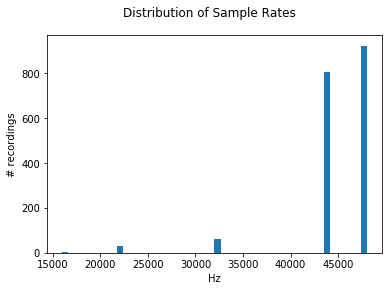

In [90]:
counts, bins, _ = plt.hist(df_train['native_sample_rate'], bins=50)
plt.suptitle("Distribution of Sample Rates")
plt.ylabel("# recordings")
plt.xlabel("Hz");

## Distribution of Recording Lengths

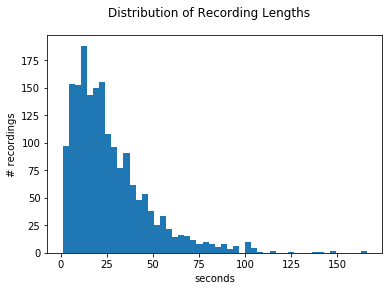

In [91]:
counts, bins, _ = plt.hist(df_train['duration_seconds'], bins=50)
plt.suptitle("Distribution of Recording Lengths")
plt.ylabel("# recordings")
plt.xlabel("seconds");

## Distribution of MFCC statistics

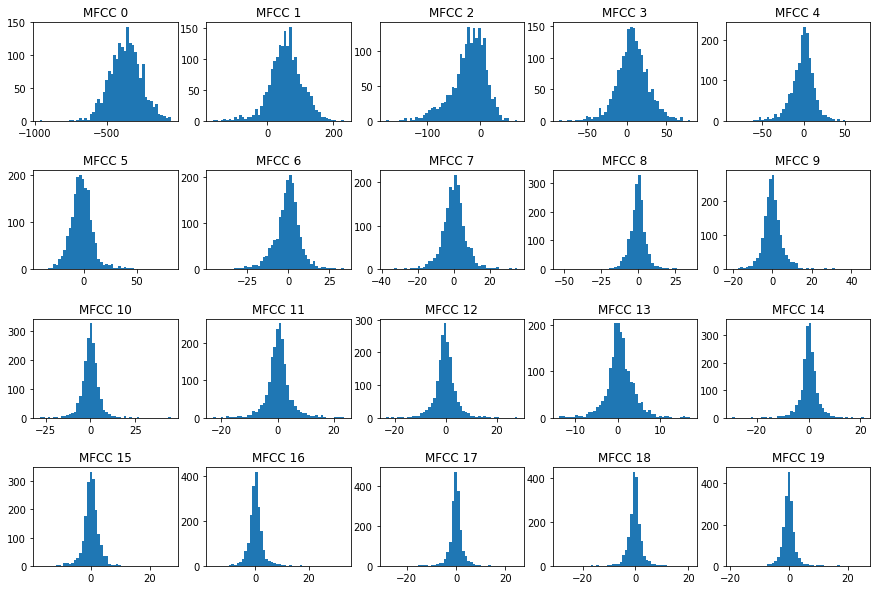

In [92]:
n_cols = 5
fig, subplots = plt.subplots(np.ceil(20/n_cols).astype(int),n_cols,
                             figsize=(15,10))
fig.subplots_adjust(hspace=.5)

for i in range(20):
    ax = subplots[int(i/n_cols)][i%n_cols]
    ax.set_title("MFCC %i"%i)
    counts, bins, _ = ax.hist(df_train['mfcc_mean%02i'%i], bins=50)

## Distribution of Average Sound Power by Freq. Band

In [137]:
mel_to_hz = __coord_mel_hz(128, fmin=msg_args['fmin'], fmax=msg_args['fmax'])

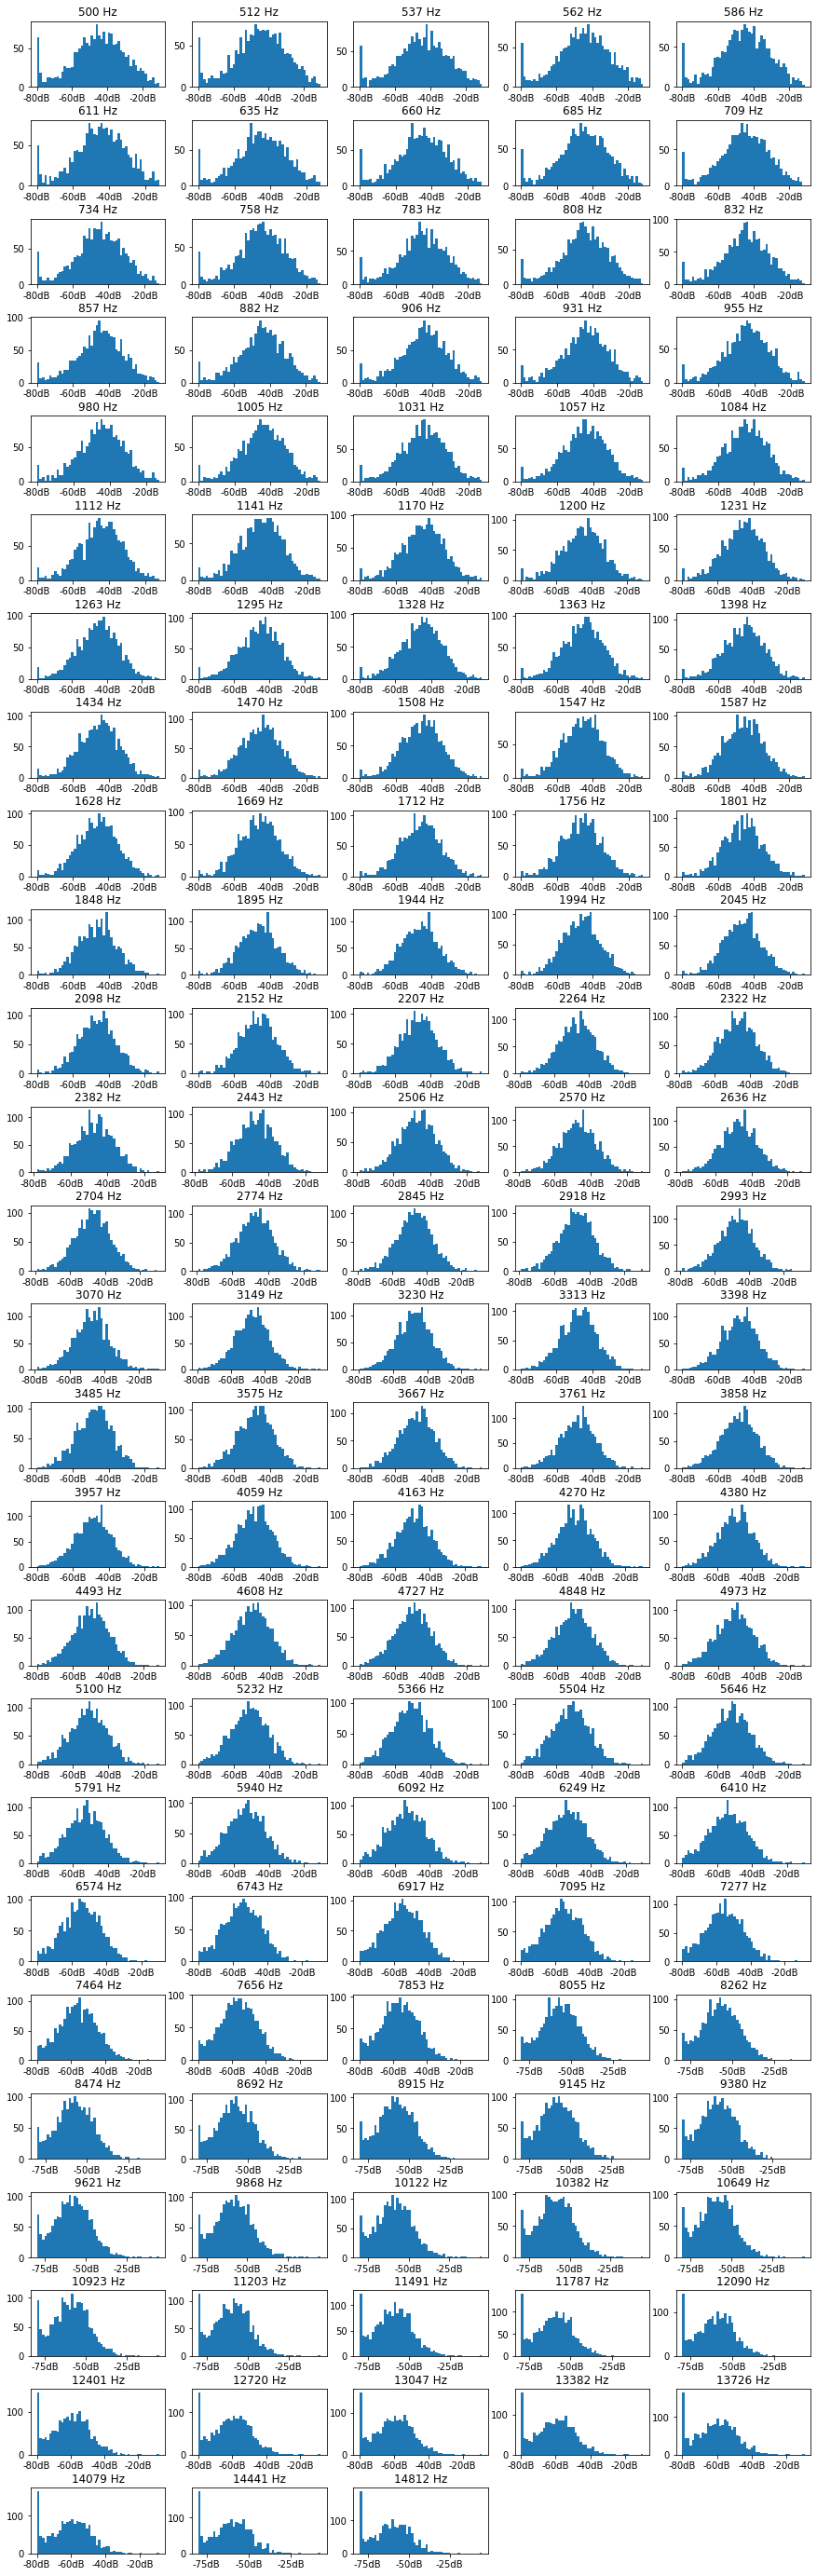

In [148]:
n_cols = 5

fig = plt.figure(figsize=(15,50))
gs = fig.add_gridspec(np.ceil(128/n_cols).astype(int), n_cols, hspace=.5)

mel_to_hz = __coord_mel_hz(128, fmin=msg_args['fmin'], fmax=msg_args['fmax'])
for i in range(128):
    ax = fig.add_subplot(gs[int(i/n_cols),i%n_cols])
    ax.set_title("%.0f Hz"%mel_to_hz[i])
    counts, bins, _ = ax.hist(df_train['meldb_mean%03i'%i], bins=50)
    ax.set_xticklabels(["%.0fdB"%t for t in ax.get_xticks()])

### Calculate the dataset-wide Mean and Variance of each MFCC / freq. band

In [95]:
def get_arr(df_idx, key):
    n_bands = 20 if key[:4]=='mfcc' else 128
    fmt_str = '%s%02i' if key[:4]=='mfcc' else '%s%03i'
    return np.array([df_train.iloc[df_idx][fmt_str % (key,idx)] for idx in range(n_bands)])

mfcc_mean = get_arr(0,'mfcc_mean')
mfcc_std = get_arr(0,'mfcc_std')
meldb_mean = get_arr(0,'meldb_mean')
meldb_std = get_arr(0,'meldb_std')
n = df_train.iloc[0]['duration_seconds']

for i in range(1,len(df_train)):
    # From answer https://stackoverflow.com/a/1480743/338676
    # and supported by https://www.emathzone.com/tutorials/basic-statistics/combined-variance.html
    # new_var=(n(0)*(var(0)+(mean(0)-new_mean)**2) +\
    #          n(1)*(var(1)+(mean(1)-new_mean)**2) + ...)/new_n
    m = df_train.iloc[i]['duration_seconds']
    mfcc_new_mean = (n*mfcc_mean + m*get_arr(i, 'mfcc_mean'))/(m+n)
    mfcc_std = np.sqrt((n*(mfcc_std**2+(mfcc_mean-mfcc_new_mean)**2) +\
                m*(get_arr(i, 'mfcc_std')**2+(get_arr(i, 'mfcc_mean')-mfcc_new_mean)**2))/(m+n))
    mfcc_mean = mfcc_new_mean
    meldb_new_mean = (n*meldb_mean + m*get_arr(i, 'meldb_mean'))/(m+n)
    meldb_std = np.sqrt((n*(meldb_std**2+(meldb_mean-meldb_new_mean)**2) +\
                m*(get_arr(i, 'meldb_std')**2+(get_arr(i,'meldb_mean')-meldb_new_mean)**2))/(m+n))
    meldb_mean = meldb_new_mean
    n += m
    print("%i/%i"%(i+1,len(df_train)), end='\r')

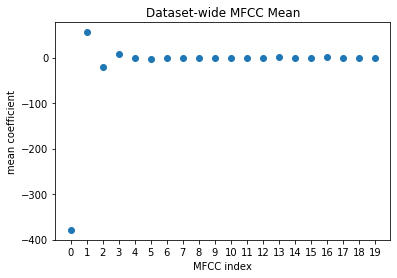

In [96]:
plt.scatter(range(len(mfcc_mean)),mfcc_mean)
plt.title("Dataset-wide MFCC Mean")
plt.ylabel("mean coefficient")
plt.xlabel("MFCC index")
plt.xticks(range(20));

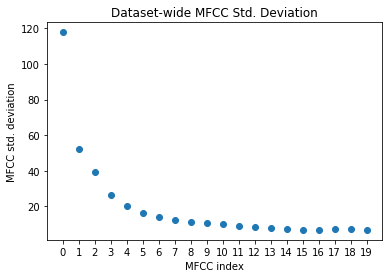

In [97]:
plt.scatter(range(len(mfcc_std)), mfcc_std)
plt.title("Dataset-wide MFCC Std. Deviation")
plt.ylabel("MFCC std. deviation")
plt.xlabel("MFCC index")
plt.xticks(range(20));

In [171]:
from librosa.display import __coord_mel_hz
# hz_lbls = [512, 1024, 2048, 4096, 8192]
# hz_lbls =[ lbl for lbl in hz_lbls if lbl>=msg_args['fmin'] and lbl<=(msg_args['fmax'] or 0) ]
hz_lbls = [500, 1000, 2000, 4000, 8000, 14000]
lbl_idx = np.searchsorted(__coord_mel_hz(128, fmin=msg_args['fmin'], fmax=msg_args['fmax']), hz_lbls)
hz_lbls = ["%s Hz"%lbl for lbl in hz_lbls]
lbl_idx

array([  0,  21,  49,  76, 103, 125], dtype=int64)

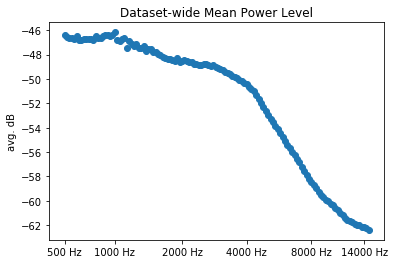

In [174]:
plt.scatter(range(len(meldb_mean)),meldb_mean)
plt.title("Dataset-wide Mean Power Level")
plt.ylabel("avg. dB")
#plt.xlim(0,128)
plt.xticks(lbl_idx, hz_lbls);

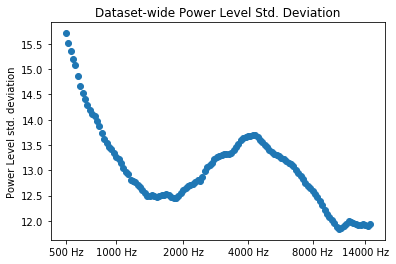

In [175]:
plt.scatter(range(len(meldb_std)), meldb_std)
plt.title("Dataset-wide Power Level Std. Deviation")
plt.ylabel("Power Level std. deviation")
plt.xticks(lbl_idx, hz_lbls);
# ax=plt.gca()
# ax.set_xlim(0,xmax=128)
# ax.set_xticklabels(['%.0fHz'%(mel_to_hz[int(t)]) for t in ax.get_xticks() if t<128]);

In [191]:
training_statistics = dict(
    mfcc_mean=list(mfcc_mean),
    mfcc_stats=list(mfcc_std),
    meldb_mean=list(meldb_mean),
    meldb_stc=list(meldb_std),
    mel_to_hz=list(mel_to_hz),
    sr=msg_args['sr'],
    n_fft=msg_args['n_fft'],
    hop_length=msg_args['hop_length'],
    fmin=msg_args['fmin'],
    fmax=msg_args['fmax'],
)
training_statistics_json = json.dumps(training_statistics, indent=2)
print(training_statistics_json)

{
  "mfcc_mean": [
    -378.7184634294044,
    55.823927048486865,
    -20.827705036599074,
    8.391456731868168,
    0.09615011825712902,
    -2.3101597841846697,
    -0.7055065568222394,
    0.16716246537525217,
    -0.41887531309778403,
    0.21598149338548978,
    0.1488200437973693,
    0.14439440239404086,
    0.022026440818245212,
    0.6659844120699353,
    0.22800319656697918,
    0.07860495049453294,
    0.38171890365959593,
    -0.15886338955191073,
    -0.2643804673245934,
    -0.10913998369868515
  ],
  "mfcc_stats": [
    117.81608640866827,
    52.01447832015254,
    39.216943649958424,
    26.386052683661564,
    20.038045683634635,
    16.440070589572517,
    13.845787189948412,
    12.454861075993072,
    11.426280994512785,
    10.864058473334252,
    10.04575691556525,
    9.157270807633434,
    8.559052584153086,
    7.525681712902923,
    7.013148763681892,
    6.718611090464043,
    6.913533204646126,
    7.1128706054049315,
    7.104404488407571,
    6.71837240

In [192]:
with open("../data/training_dataset_statistics.json",'w') as f:
    f.write(training_statistics_json)